# Import Library

In [1]:
import numpy as np
import pandas as pd
import random

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from gwo import GreyWolfOptimizer
from sklearn.metrics import log_loss, roc_auc_score


# Import Dataset

In [2]:
trainValData = pd.read_csv("dataset/train_val.data")
testData = pd.read_csv("dataset/test.data")

X_trainVal = trainValData.drop(columns=["Diagnosis"])
y_trainVal = trainValData["Diagnosis"]

X_test = testData.drop(columns=["Diagnosis"])
y_test = testData["Diagnosis"]


# 80% train 20% test

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_trainVal,
    y_trainVal,
    test_size=0.2,
    random_state=1,
    stratify=y_trainVal
)

# Baseline XGBoost

In [4]:
baselineModel = XGBClassifier(
    n_estimators=350,
    max_depth=8,
    learning_rate=0.15,
    subsample=0.95,
    colsample_bytree=1,
    eval_metric="logloss",
    random_state=1
)

baselineModel.fit(X_trainVal, y_trainVal)

y_pred_baseline = baselineModel.predict(X_test)

baselineResults = {
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "Precision": precision_score(y_test, y_pred_baseline),
    "Recall": recall_score(y_test, y_pred_baseline),
    "F1": f1_score(y_test, y_pred_baseline),
    "AUC": roc_auc_score(y_test,y_pred_baseline)
}

baselineResults


{'Accuracy': 0.9736842105263158,
 'Precision': 0.975609756097561,
 'Recall': 0.9523809523809523,
 'F1': 0.963855421686747,
 'AUC': 0.9692460317460317}

# Fungsi Objektif GWO

In [5]:
def xgboostObjectiveFunction(position):
    n_estimators = int(position[0])
    max_depth = int(position[1])
    learning_rate = position[2]
    subsample = position[3]
    colsample_bytree = position[4]

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="logloss",
        random_state=1
    )

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    fitness = log_loss(y_val, y_pred_proba) + (1 - roc_auc_score(y_val, y_pred_proba))*0.1
    return fitness

# GWO-XGBoost Model

Iterasi 1/50 | Best Fitness: 0.045174
Iterasi 2/50 | Best Fitness: 0.043099
Iterasi 3/50 | Best Fitness: 0.043099
Iterasi 4/50 | Best Fitness: 0.042076
Iterasi 5/50 | Best Fitness: 0.040995
Iterasi 6/50 | Best Fitness: 0.040809
Iterasi 7/50 | Best Fitness: 0.040809
Iterasi 8/50 | Best Fitness: 0.040809
Iterasi 9/50 | Best Fitness: 0.040181
Iterasi 10/50 | Best Fitness: 0.040181
Iterasi 11/50 | Best Fitness: 0.039248
Iterasi 12/50 | Best Fitness: 0.039248
Iterasi 13/50 | Best Fitness: 0.039248
Iterasi 14/50 | Best Fitness: 0.039248
Iterasi 15/50 | Best Fitness: 0.039248
Iterasi 16/50 | Best Fitness: 0.037624
Iterasi 17/50 | Best Fitness: 0.037624
Iterasi 18/50 | Best Fitness: 0.037624
Iterasi 19/50 | Best Fitness: 0.037624
Iterasi 20/50 | Best Fitness: 0.037624
Iterasi 21/50 | Best Fitness: 0.037624
Iterasi 22/50 | Best Fitness: 0.037624
Iterasi 23/50 | Best Fitness: 0.037624
Iterasi 24/50 | Best Fitness: 0.037624
Iterasi 25/50 | Best Fitness: 0.037624
Iterasi 26/50 | Best Fitness: 0.03

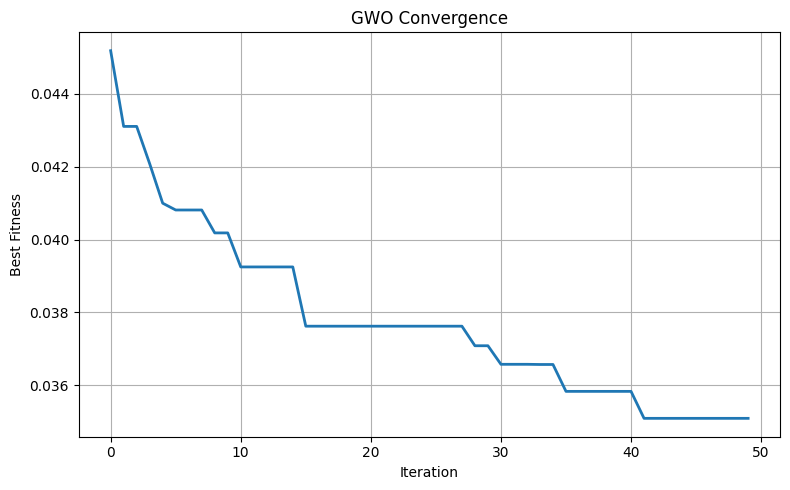


=== BEST PARAMETER FROM GWO ===
n_estimators : 318
max_depth   : 6
learning_rate: 0.14938536426768378
subsample : 0.6789057307745135
colsample_bytree : 0.670037868149102


In [6]:
gwo = GreyWolfOptimizer(
    objectiveFunction=xgboostObjectiveFunction,
    lowerBound = [150, 4, 0.01, 0.6, 0.6],
    upperBound = [350, 8, 0.15, 0.95, 1],
    dimension=5
)

gwoResult = gwo.optimize()

bestParams = gwoResult["bestPosition"]

print("\n=== BEST PARAMETER FROM GWO ===")
print("n_estimators :", int(bestParams[0]))
print("max_depth   :", int(bestParams[1]))
print("learning_rate:", bestParams[2])
print("subsample :", bestParams[3])
print("colsample_bytree :", bestParams[4])

# Parameter ALpha

In [7]:
bestParamsDict = {
    "n_estimators": int(bestParams[0]),
    "max_depth": int(bestParams[1]),
    "learning_rate": bestParams[2],
    "subsample": bestParams[3],
    "colsample_bytree": bestParams[4]
}

bestParamsDict

{'n_estimators': 318,
 'max_depth': 6,
 'learning_rate': np.float64(0.14938536426768378),
 'subsample': np.float64(0.6789057307745135),
 'colsample_bytree': np.float64(0.670037868149102)}

# Metrik Evaluasi GWO-XGBoost

In [8]:
finalModel = XGBClassifier(
    n_estimators=bestParamsDict["n_estimators"],
    max_depth=bestParamsDict["max_depth"],
    learning_rate=bestParamsDict["learning_rate"],
    subsample=bestParamsDict["subsample"],
    colsample_bytree=bestParamsDict["colsample_bytree"],
    eval_metric="logloss",
    random_state=1
)

finalModel.fit(X_trainVal, y_trainVal)

y_pred_gwo = finalModel.predict(X_test)

gwoResults = {
    "Accuracy": accuracy_score(y_test, y_pred_gwo),
    "Precision": precision_score(y_test, y_pred_gwo),
    "Recall": recall_score(y_test, y_pred_gwo),
    "F1": f1_score(y_test, y_pred_gwo),
    "AUC": roc_auc_score(y_test,y_pred_gwo)
}

gwoResults

{'Accuracy': 0.9649122807017544,
 'Precision': 0.9523809523809523,
 'Recall': 0.9523809523809523,
 'F1': 0.9523809523809523,
 'AUC': 0.9623015873015873}

# Tabel Komparasi

In [9]:
comparison = pd.DataFrame(
    [baselineResults, gwoResults],
    index=["Baseline XGBoost", "XGBoost + GWO"]
)

comparison

,Accuracy,Precision,Recall,F1,AUC
Baseline XGBoost,0.973684,0.975610,0.952381,0.963855,0.969246
XGBoost + GWO,0.964912,0.952381,0.952381,0.952381,0.962302
